In [4]:
import json
import twint
import nest_asyncio
from collections import Counter
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import networkx as nx
from pandas import Grouper
from pylab import rcParams

# Constructing the Data Set

In [5]:
data_folder = Path('../data/twint')
tweets_file = data_folder / 'data_new2.txt'

NameError: name 'Path' is not defined

In [112]:
f = open(tweets_file, 'r')
lines = [l for l in f]
f.close()

In [113]:
tweets = [json.loads(l) for l in lines]
print('Number of tweets read in:\t%s' % len(tweets))

Number of tweets read in:	51853


# Tweet Time Distribution

In [ ]:
dates_to_n_tweets = {}

for t in tweets:
    date = t['date'].split('-')[1] + '-' + t['date'].split('-')[2]
    try:
        dates_to_n_tweets[date] = dates_to_n_tweets[date] + 1
    except:
        dates_to_n_tweets[date] = 0

sorted_dates = sorted(dates_to_n_tweets.items())
plt.figure(1, figsize=(40, 20))
plt.bar([e[0] for e in sorted_dates], [e[1] for e in sorted_dates])
plt.title('Number of Tweets per Day', fontsize=20)
plt.xlabel('Day', fontsize=20)
plt.ylabel('Number of Tweets', fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.savefig('tweet_time_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Get most popular Uber-related hashtags

In [ ]:
hashtags = [h for t in tweets for h in t['hashtags']]

In [ ]:
from collections import Counter
hashtags_count = pd.DataFrame.from_dict(Counter(hashtags), orient='index', columns=['count']).sort_values(by='count', ascending=False)[:10]
hashtags_count

In [ ]:
all_hashtags = []
for t in tweets:
    hashtags = t['hashtags']
    for h in hashtags:
        all_hashtags.append(h)
                                  
hashtags_counter = Counter(all_hashtags)
hashtag_count_df = pd.DataFrame.from_dict(hashtags_counter, orient='index', columns=['count']).sort_values(by=['count'], ascending=False).head(10)
hashtag_count_df.plot(kind='bar', legend=False, figsize=(15, 5), fontsize=20)
plt.title('Hashtag Occurrences', fontsize=20)
plt.xticks(rotation=45)
plt.savefig('hashtag_occurrences.pdf', bbox_inches='tight')
plt.show()
plt.close()

### Hashtag Occurrences

Total number of tweets: 51853
Number of tweets without hashtags: 13


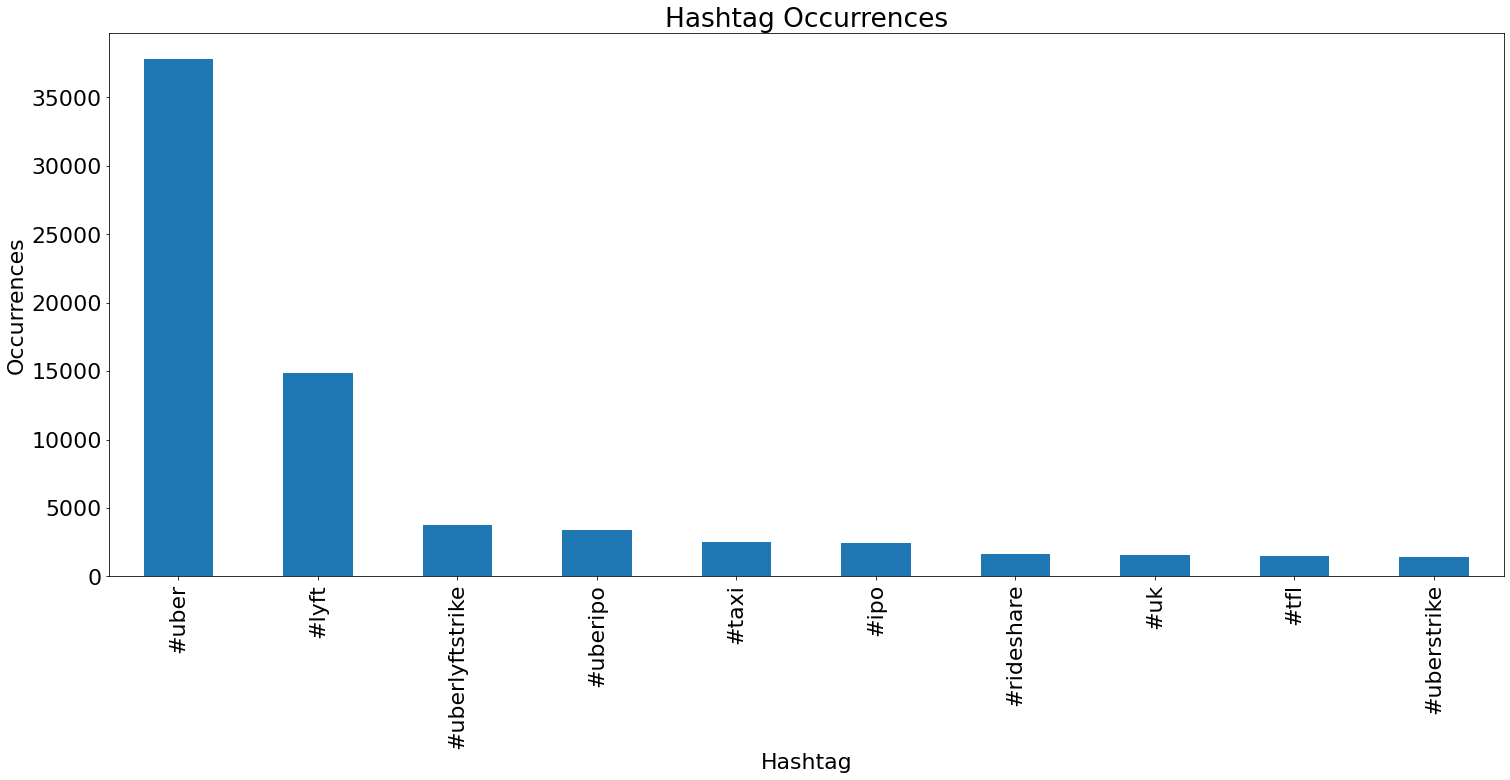

In [8]:
all_hashtags = []
hashtag_pairs = []
tweets_without_hashtags = []
for t in tweets:
    hashtags = t['hashtags']
    if len(hashtags) == 0:
        tweets_without_hashtags.append(t)
    pairs = combinations(hashtags, r=2)
    for pair in pairs:
        hashtag_pairs.append(pair)
    for h in hashtags:
        all_hashtags.append(h)
                                  
print("Total number of tweets: %d" % len(tweets))
print("Number of tweets without hashtags: %d" % len(tweets_without_hashtags))
hashtags_counter = Counter(all_hashtags)
hashtag_count_df = pd.DataFrame.from_dict(hashtags_counter, orient='index', columns=['count']).sort_values(by=['count'], ascending=False).head(10)
ax = hashtag_count_df.plot(kind='bar', legend=False, title='Hashtag Occurrences', figsize=(25, 10),)
ax.set_xlabel('Hashtag')
ax.set_ylabel('Occurrences')
plt.show()

### Hashtag Co-ocurrences

{'#uber': 8, '#tfl': 3, '#taxi': 3, '#lyft': 3, '#ipo': 1, '#edm': 2, '#crypto': 3, '#uk': 3, '#np': 2}


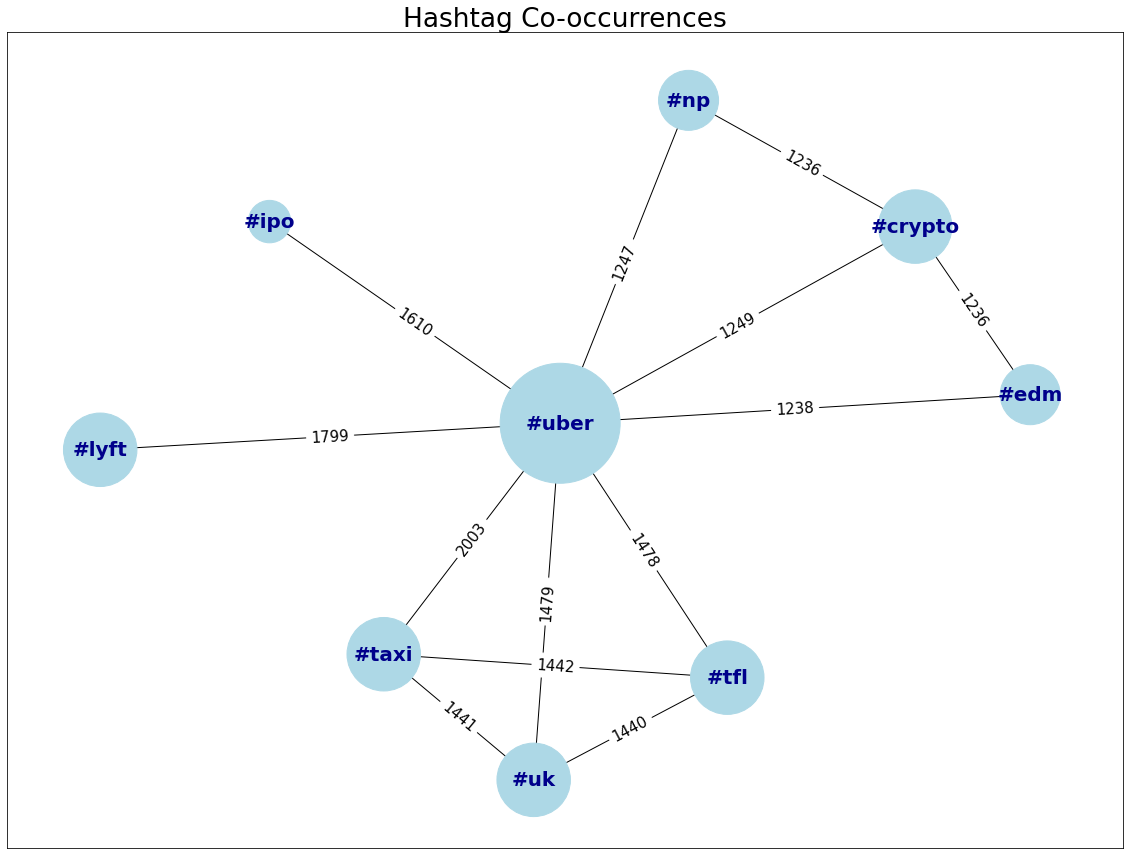

In [10]:
pairs_counter = Counter(hashtag_pairs)

hashtags_in_most_common_pairs = []
for t in pairs_counter.most_common(15):
    hashtags_in_most_common_pairs.append(t[0][0])
    hashtags_in_most_common_pairs.append(t[0][1])

hashtags_in_most_common_pairs = list(set(hashtags_in_most_common_pairs))

G = nx.Graph()
G.add_nodes_from(hashtags_in_most_common_pairs)
G.add_weighted_edges_from([(t[0][0], t[0][1], pairs_counter[t[0]]) for t in pairs_counter.most_common(15)])
d = dict(G.degree)
print(d)
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
plt.figure(1, figsize=(20, 15))
plt.margins(0.1, 0.1)
nx.draw_networkx(G,pos, font_weight='bold', node_size=[v * 1800 for v in d.values()], font_color='darkblue', node_color='lightblue', font_size=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, width=40, font_size=15)
plt.title('Hashtag Co-occurrences')
plt.savefig('hashtag_cooccurences.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Hashtag Timelines

In [11]:
hashtags_dates = {}
unique_hashtags = set(all_hashtags)
for hashtag in unique_hashtags:
    hashtags_dates[hashtag] = {}

all_dates = [t['date'] for t in tweets]
for d in all_dates:
    for h in hashtags_dates.keys():
        hashtags_dates[h][d] = 0

for t in tweets:
    hashtags = t['hashtags']
    date = t['date']
    for h in hashtags:
        count = hashtags_dates[h][date]
        if count == 0:
            hashtags_dates[h][date] = 1
        else:
            hashtags_dates[h][date] += 1

In [12]:
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(hashtags_dates, orient='index')
df['total'] = df[list(df.columns)].sum(axis=1)
df = df.sort_values(by=['total'], ascending=False)

top_10 = df.head(10).transpose()[::-1].drop(['total'])
top_10 = top_10.transpose()

fig, axes = plt.subplots(5, 2, figsize=(25, 13))
plt.subplots_adjust(hspace=2, wspace=0.2)
fig.suptitle('Hashtag Occurences over Time', fontsize=22)

for i in range(5):
    row = top_10.iloc[[i]]
    ax = row.transpose().plot(ax=axes[i][0], kind='bar', legend=False, fontsize=18)
    ax.set_title(row.index[0], fontsize=20)
    xlabels = [date.split('-')[2] for date in row.columns]
    ax.set_xticklabels(xlabels, fontsize=12)
    
for i in range(5, 10):
    row = top_10.iloc[[i]]
    ax = row.transpose().plot(ax=axes[i-5][1], kind='bar', legend=False, fontsize=18)
    ax.set_title(row.index[0], fontsize=20)
    xlabels = [date.split('-')[2] for date in row.columns]
    ax.set_xticklabels(xlabels, fontsize=12)

plt.savefig('hashtag_occurence_over_time.pdf', bbox_inches='tight')
plt.close()